In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix

# Configuración de estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Rutas relativas (Asumiendo que el notebook está en la carpeta 'notebooks')
RESULTS_DIR = '../results'
LOGS_DIR = os.path.join(RESULTS_DIR, 'logs')
REPORTS_DIR = os.path.join(RESULTS_DIR, 'reports')
PLOTS_DIR = os.path.join(RESULTS_DIR, 'plots')
CHECKPOINT_DIR = os.path.join(RESULTS_DIR, 'checkpoints')

print("Entorno configurado.")

Entorno configurado.


# 8.1 Experimento 1: Comparación de Arquitecturas
**Objetivo:** Evaluar el rendimiento de LSTM (Uni/Bi) y GRU, con y sin mecanismos de atención.
**Métricas:** F1-Score (Weighted) y Tiempo de Entrenamiento.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9748\741919420.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x='best_val_f1', y='experiment', palette='viridis')


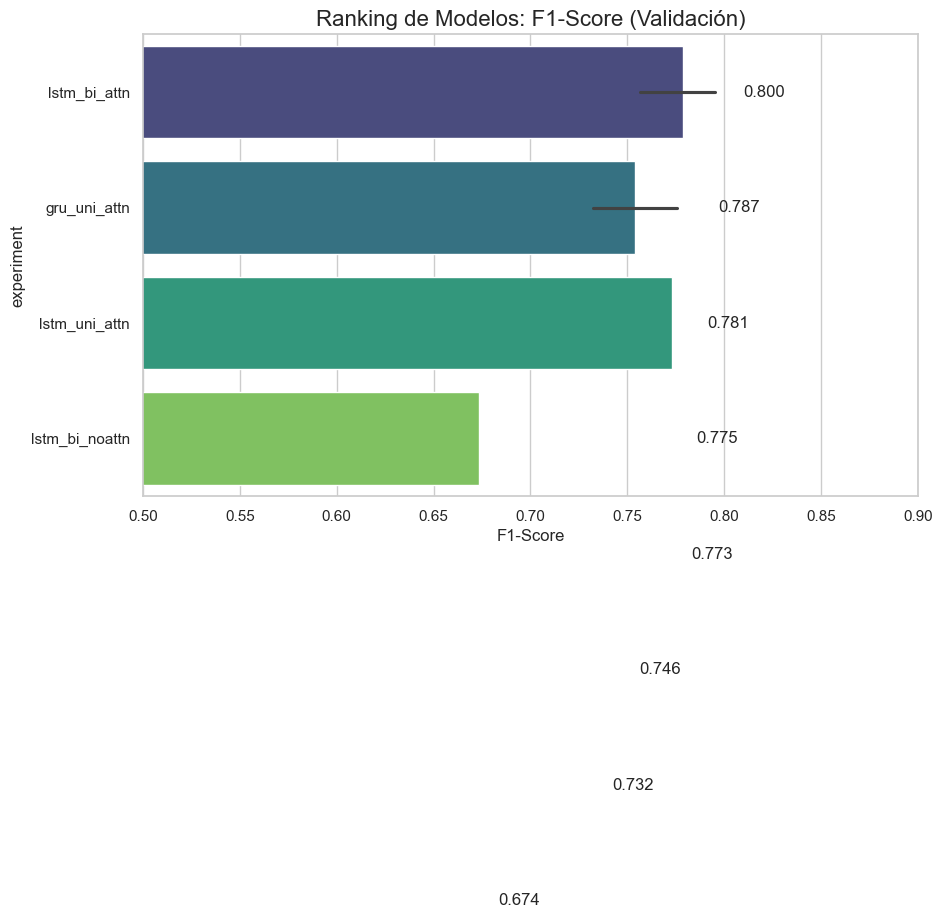

Tabla Resumen:


,experiment,best_val_f1,best_val_loss
0,lstm_bi_attn,0.799757,0.748986
1,lstm_bi_attn,0.786713,0.757998
2,lstm_bi_attn,0.781119,0.662303
3,gru_uni_attn,0.775444,0.698396
4,lstm_uni_attn,0.773153,0.714954
5,lstm_bi_attn,0.746401,0.707999
6,gru_uni_attn,0.732118,0.681496
7,lstm_bi_noattn,0.673527,0.836141


In [2]:
# Cargar el resumen generado por engine.py
summary_path = os.path.join(RESULTS_DIR, 'reports', 'final_experiment_summary.csv')

if os.path.exists(summary_path):
    df_summary = pd.read_csv(summary_path)
    
    # 1. Gráfico de Barras: Ranking F1-Score
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_summary, x='best_val_f1', y='experiment', palette='viridis')
    plt.title("Ranking de Modelos: F1-Score (Validación)", fontsize=16)
    plt.xlabel("F1-Score")
    plt.xlim(0.5, 0.9) # Ajustar límites para ver mejor las diferencias
    
    # Poner etiquetas de valor
    for i, v in enumerate(df_summary['best_val_f1']):
        ax.text(v + 0.01, i, f"{v:.3f}", va='center')
        
    plt.show()
    
    # Mostrar tabla completa
    print("Tabla Resumen:")
    display(df_summary[['experiment', 'best_val_f1', 'best_val_loss']])
else:
    print("No se encontró el resumen. Ejecuta engine.py primero.")

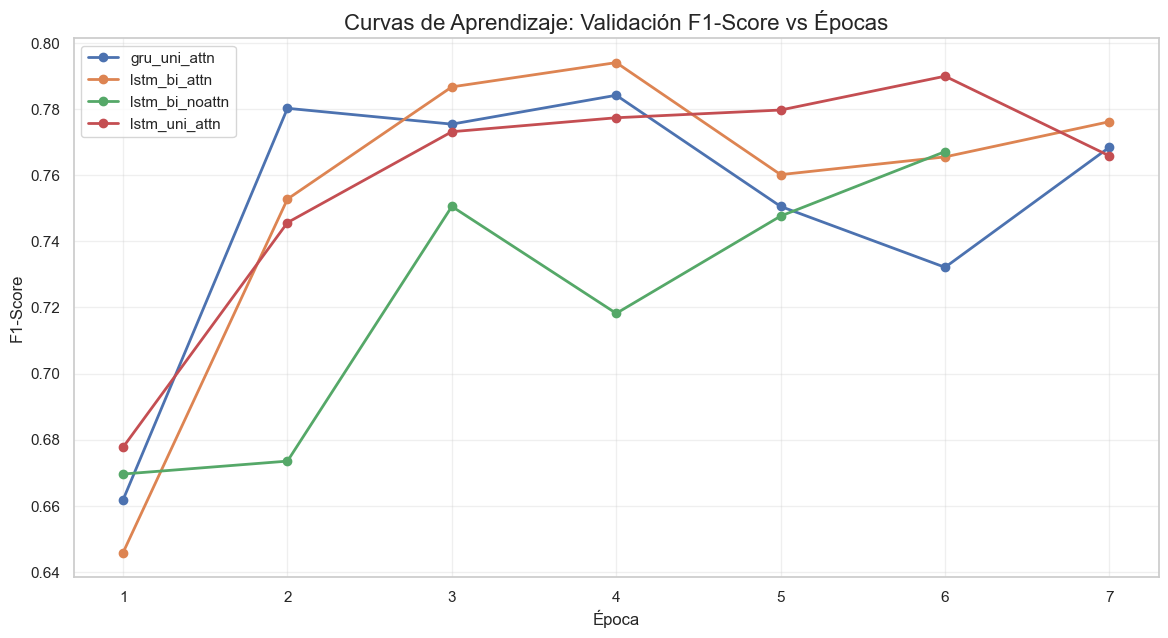

In [3]:
# Cargar logs individuales para ver evolución
log_files = [f for f in os.listdir(LOGS_DIR) if f.endswith('.csv')]
dfs_logs = {}

plt.figure(figsize=(14, 7))

for file in log_files:
    # Nombre limpio
    name = file.replace('log_', '').replace('.csv', '')
    df = pd.read_csv(os.path.join(LOGS_DIR, file))
    dfs_logs[name] = df
    
    # Graficar curva de validación
    plt.plot(df['epoch'], df['val_f1'], marker='o', label=name, linewidth=2)

plt.title("Curvas de Aprendizaje: Validación F1-Score vs Épocas", fontsize=16)
plt.xlabel("Época")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

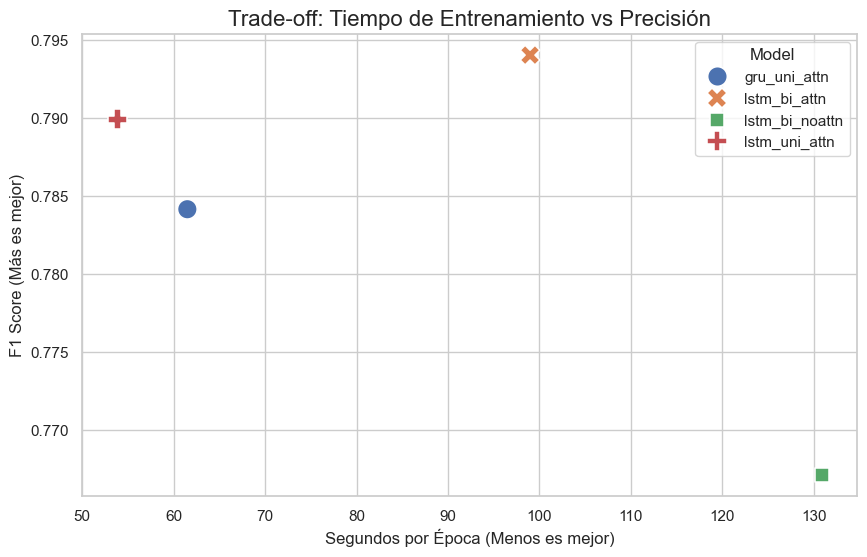

,Model,Time (s),F1
1,lstm_bi_attn,98.965964,0.794060
3,lstm_uni_attn,53.847051,0.789944
0,gru_uni_attn,61.487557,0.784180
2,lstm_bi_noattn,130.897979,0.767135


In [4]:
# Extraer tiempos promedio de los logs
times = []
for name, df in dfs_logs.items():
    avg_time = df['time_epoch'].mean() # o time_mins
    best_f1 = df['val_f1'].max()
    times.append({'Model': name, 'Time (s)': avg_time, 'F1': best_f1})

df_times = pd.DataFrame(times)

# Scatter plot: Eficiencia
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_times, x='Time (s)', y='F1', s=200, hue='Model', style='Model')
plt.title("Trade-off: Tiempo de Entrenamiento vs Precisión", fontsize=16)
plt.xlabel("Segundos por Época (Menos es mejor)")
plt.ylabel("F1 Score (Más es mejor)")
plt.grid(True)
plt.show()

display(df_times.sort_values(by='F1', ascending=False))

# 8.2 Experimento 2: Análisis de Contexto
**Objetivo:** Determinar la capacidad del modelo para manejar dependencias largas (tweets extensos) y elementos lingüísticos complejos como sarcasmo y negaciones.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9748\3485758262.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_len = df_det.groupby('len_group')['is_correct'].mean().reset_index()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9748\3485758262.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_by_len, x='len_group', y='is_correct', palette='magma')


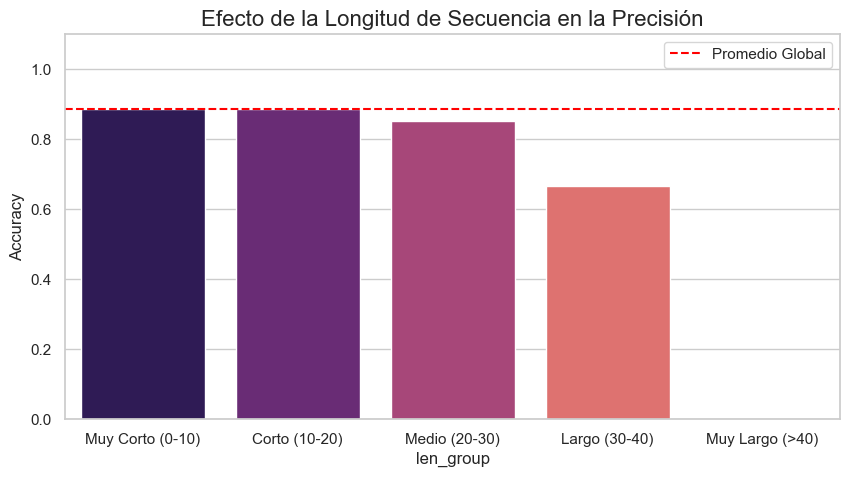

Conclusión: Las barras muestran si el modelo olvida el contexto en secuencias largas.


In [5]:
# Cargar reporte detallado del mejor modelo (generado por tester.py)
report_path = os.path.join(REPORTS_DIR, 'best_model_detailed_analysis.csv')

if os.path.exists(report_path):
    df_det = pd.read_csv(report_path)
    
    # Crear grupos de longitud
    bins = [0, 10, 20, 30, 40, 100]
    labels = ['Muy Corto (0-10)', 'Corto (10-20)', 'Medio (20-30)', 'Largo (30-40)', 'Muy Largo (>40)']
    df_det['len_group'] = pd.cut(df_det['length'], bins=bins, labels=labels)
    
    # Calcular accuracy por grupo
    acc_by_len = df_det.groupby('len_group')['is_correct'].mean().reset_index()
    
    # Gráfico
    plt.figure(figsize=(10, 5))
    sns.barplot(data=acc_by_len, x='len_group', y='is_correct', palette='magma')
    plt.axhline(df_det['is_correct'].mean(), color='red', linestyle='--', label='Promedio Global')
    plt.title("Efecto de la Longitud de Secuencia en la Precisión", fontsize=16)
    plt.ylim(0, 1.1)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    print("Conclusión: Las barras muestran si el modelo olvida el contexto en secuencias largas.")

### Manejo de Sarcasmo y Negaciones (Mapas de Atención)


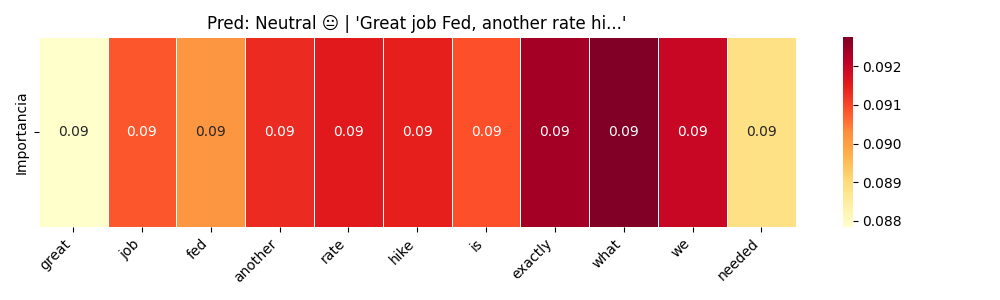

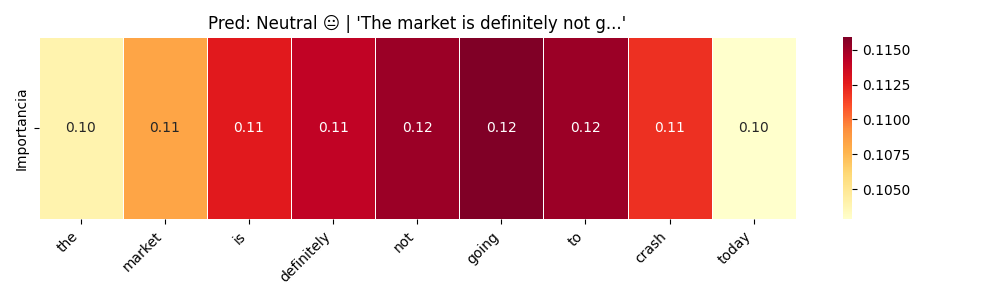

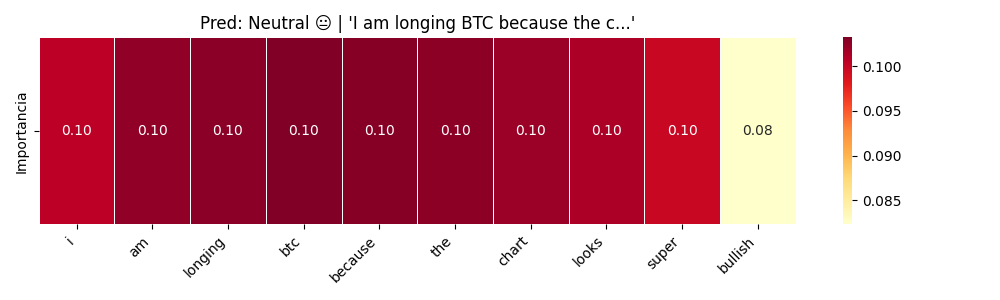

In [6]:
# Cargar imágenes generadas por visualize.py
print("### Manejo de Sarcasmo y Negaciones (Mapas de Atención)")

imgs = ['attn_sarcasm.png', 'attn_negation.png', 'attn_jargon.png']
for img in imgs:
    path = os.path.join(PLOTS_DIR, img)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print(f"Falta imagen {img}. Ejecuta visualize.py")

# 8.3 Experimento 3: Robustez y Análisis de Errores
**Objetivo:** Analizar dónde falla el modelo y su sensibilidad a cambios en hiperparámetros.

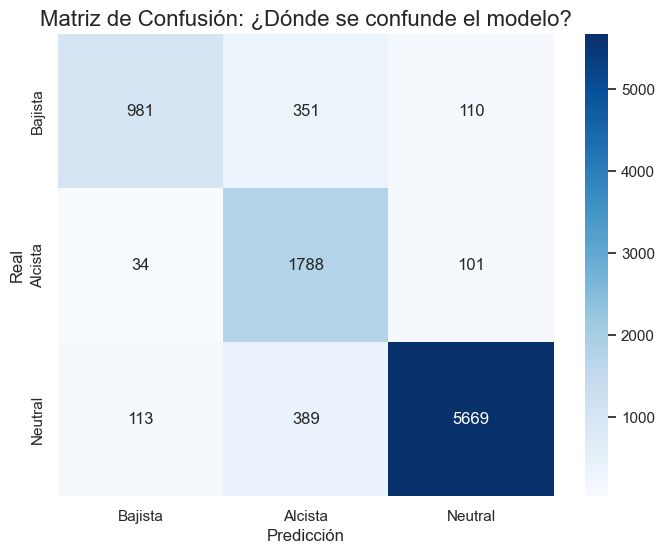

In [7]:
if os.path.exists(report_path):
    # Calcular matriz
    y_true = df_det['label_true']
    y_pred = df_det['label_pred']
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualizar
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bajista', 'Alcista', 'Neutral'],
                yticklabels=['Bajista', 'Alcista', 'Neutral'])
    plt.title("Matriz de Confusión: ¿Dónde se confunde el modelo?", fontsize=16)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

In [8]:
if os.path.exists(report_path):
    # Filtrar errores
    errors = df_det[df_det['is_correct'] == False].copy()
    
    # Si tenemos confianza, mostrar los errores donde el modelo estaba "muy seguro"
    if 'confidence' in errors.columns:
        critical_errors = errors.sort_values(by='confidence', ascending=False).head(5)
        print("Top 5 Errores con Mayor Confianza (Falsos Positivos Severos):")
    else:
        critical_errors = errors.head(5)
        print("Ejemplos de Errores:")
        
    for i, row in critical_errors.iterrows():
        print(f"\nTweet: {row['original_text']}")
        print(f"Longitud: {row['length']}")
        print(f"Real: {row['label_true']} | Predicho: {row['label_pred']} (Conf: {row.get('confidence', 0):.2f})")
        print("-" * 50)

Top 5 Errores con Mayor Confianza (Falsos Positivos Severos):

Tweet: s p <TICKER> with 5000 june 319 calls opening in a 5m position as december 298 calls adjust
Longitud: 18
Real: 1 | Predicho: 2 (Conf: 1.00)
--------------------------------------------------

Tweet: target has morphed into a model for how to avoid the retail apocalypse
Longitud: 14
Real: 1 | Predicho: 2 (Conf: 0.99)
--------------------------------------------------

Tweet: fun fact there are about 35 million people still in credit card debt from last year s round of holiday shopping h
Longitud: 7
Real: 0 | Predicho: 2 (Conf: 0.99)
--------------------------------------------------

Tweet: goldman partner embroiled in 1mdb scandal exits bank ft
Longitud: 12
Real: 0 | Predicho: 2 (Conf: 0.99)
--------------------------------------------------

Tweet: some officials worried about the bank s decision to drop self imposed limits on the ecb s bond purchases
Longitud: 21
Real: 0 | Predicho: 2 (Conf: 0.99)
-----------------

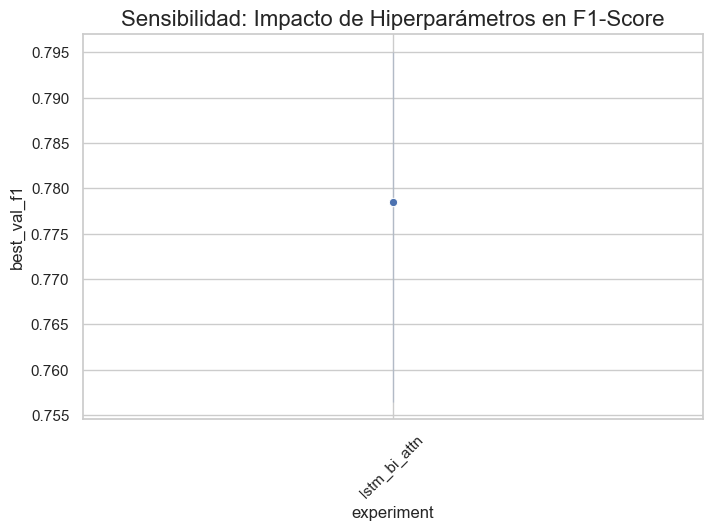

In [9]:
# Comparar impacto de Hidden Dim (filtrando del resumen)
if os.path.exists(summary_path):
    # Filtramos solo los experimentos LSTM Bidireccionales con Atención para ver efecto de Hidden
    # Nota: Esto asume que tienes nombres como 'lstm_bi_attn_h128', 'lstm_bi_attn_h256' en tu CSV
    # Si no, ajusta el filtro str.contains
    
    df_hidden = df_summary[df_summary['experiment'].str.contains('lstm_bi_attn')]
    
    if not df_hidden.empty:
        plt.figure(figsize=(8, 5))
        sns.lineplot(data=df_hidden, x='experiment', y='best_val_f1', marker='o')
        plt.title("Sensibilidad: Impacto de Hiperparámetros en F1-Score", fontsize=16)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No hay suficientes datos variados para graficar sensibilidad.")

# Extras: Explicabilidad (SHAP) y Ensemble

### Importancia de Características (SHAP)


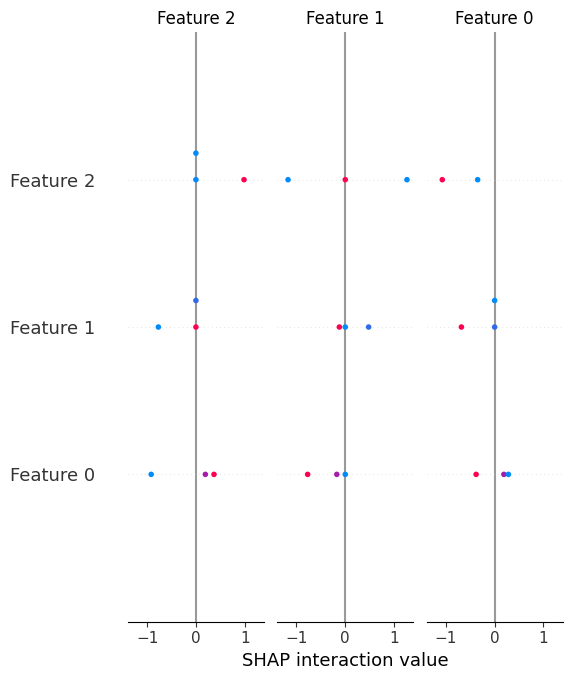

Accuracy Mejor Individual: 0.8849
Accuracy Ensemble:        0.9187
El Ensemble mejoró el resultado en 3.39%


In [10]:
# SHAP
print("### Importancia de Características (SHAP)")
shap_img = os.path.join(PLOTS_DIR, 'shap_summary.png')
if os.path.exists(shap_img):
    display(Image(filename=shap_img))
else:
    print("Falta gráfico SHAP.")

# Ensemble
ens_path = os.path.join(REPORTS_DIR, 'ensemble_results.csv')
if os.path.exists(ens_path) and os.path.exists(report_path):
    df_ens = pd.read_csv(ens_path)
    acc_ens = df_ens['is_correct'].mean()
    acc_best = df_det['is_correct'].mean()
    
    print(f"Accuracy Mejor Individual: {acc_best:.4f}")
    print(f"Accuracy Ensemble:        {acc_ens:.4f}")
    
    if acc_ens > acc_best:
        print(f"El Ensemble mejoró el resultado en {(acc_ens - acc_best)*100:.2f}%")